<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/base/Lecture1_NormFlows/huggingface_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дообучение моделей из Huggingface

In [ ]:
!pip install -qq transformers datasets

## Загрузка датасета, исследование данных и их обработка

In [ ]:
!gdown --id 10dSjHPFHMo_1ibIFXKd2m6ncQITwlimG
!gdown --id 1SD5mxKGbiM5gYZKThenKncf1QzEldkqb

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10dSjHPFHMo_1ibIFXKd2m6ncQITwlimG
To: /content/negative_twitter.csv
100% 24.5M/24.5M [00:00<00:00, 29.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SD5mxKGbiM5gYZKThenKncf1QzEldkqb
To: /content/positive_twitter.csv
100% 26.2M/26.2M [00:01<00:00, 24.6MB/s]


In [ ]:
import pandas as pd

pos_texts = pd.read_csv('positive_twitter.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('negative_twitter.csv', encoding='utf8', sep=';', header=None)

df = pd.concat([pos_texts, neg_texts], axis=0)
df = df[[3, 4]]
df.columns = ['text', 'labels']
df.labels = df.labels.map({1: 1, -1: 0})
df.head()

,text,labels
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [ ]:
df.labels.value_counts()

,count
labels,
1,114911
0,111923


In [ ]:
# перемешиваем и выбираем 20к примеров для скорости обучения
df = df.sample(frac=1.0).reset_index(drop=True)[:20000]

In [ ]:
df.labels.value_counts()

,count
labels,
1,10150
0,9850


In [ ]:
df.head()

,text,labels
0,"Я начал слушать свои треки,и понял сколько там...",1
1,"Господи,на почте простояла 1,5 часа,опаздала н...",0
2,Поздравите меня с этими прекрасными ушами)) #м...,1
3,@tanusha_bukusha ну я ж чай подруга)) мне поло...,1
4,"Как-то немного грустно становится, из-за того ...",0


#### Очистка текста

In [ ]:
!pip install -qq pymorphy2 pymorphy2-dicts-ru

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 78.2 MB/s eta 0:00:00


In [ ]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure that nltk's stopwords are downloaded (you've done this)
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import inspect

if not hasattr(inspect, 'getargspec'):
    def getargspec(func):
        spec = inspect.getfullargspec(func)
        return spec.args, spec.varargs, spec.varkw, spec.defaults
    inspect.getargspec = getargspec

import pymorphy2
morph = pymorphy2.MorphAnalyzer()


# Функция для предобработки текста
def preprocess_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Удаляем никнеймы, хэштеги, URL-адреса и символы новой строки
    text = re.sub(r'@\w+|#[\w-]+|http\S+|\n', '', text)

    # Удаляем пунктуацию, не разделяя слова и знаки препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизируем текст для более точного разделения на слова
    words = word_tokenize(text, language='russian')

    # Фильтрация слов, состоящих только из подчеркиваний
    words = [word for word in words if not re.match(r'^_+$', word)]

    # Инициализация списка для нормализованных слов
    processed_words = []

    for word in words:
        try:
            # Нормализация слова
            p = morph.parse(word)[0]
            word = p.normal_form
        except:
            # Если нормализация не удастся, используем исходное слово
            pass

        # Исключение стоп-слов можно сделать опциональным т.к. иногда искажает смысл
        # if word not in russian_stopwords:
        processed_words.append(word)

    # Соединяем обработанные слова в строку
    return ' '.join(processed_words)

for i in np.random.randint(0, len(df), 5):
    print('Ориг:', df['text'][i])
    print('Чист:', preprocess_text(df['text'][i]), '\n')

Ориг: 7 школа, дошел слух, что и у вас там ничего не грузится)
Чист: 7 школа дойти слух что и у вы там ничего не грузиться 

Ориг: RT @wyrudezyper: среди софта в топе на мининове практически всё связано с win7. как-то снизу там прилепился касперыч :)
Чист: rt среди софт в топ на мининов практически всё связать с win7 както снизу там прилепиться касперыч 

Ориг: Работа на конюшне убивает(((( @ КСК Московия http://t.co/ujJHzeCZeo
Чист: работа на конюшня убивать кск московия 

Ориг: Зато посетил наконец Дедовых ^^ крутая квартира у них, Дашка прикольная :)
Чист: зато посетить наконец дедов крутой квартира у они дашка прикольный 

Ориг: @potemkovskaya даже подъебать не на что((
Чист: даже подъебать не на что 



In [ ]:
df_cleared = df.copy()
df_cleared['text'] = df['text'].apply(preprocess_text)

In [ ]:
df_cleared.sample(5)

,text,labels
18188,angry birds по украински плакат,1
5573,он прям как с тот комикс типо мой кот флиртова...,1
5426,занятой да ваптать d работать день и ночь ночь,1
13241,но всё же начало год и июль обещать быть очень...,1
19929,rt а ещё у я совершенно не получиться сайка и ...,0


In [ ]:
df_cleared.to_csv('df_cleared.csv', index=False)

# Загрузка модели и подготовка датасета к обучению

`AutoModel` - класс для инициализации любой модели на основе заданной контрольной точки.

Класс AutoModel вместе с его производными представляет собой универсальные интерфейсы для обширного набора моделей, доступных в библиотеке. Главная его особенность заключается в способности автоматически определять, какая архитектура модели наилучшим образом соответствует предоставленной контрольной точке (заданной текстовым описанием), и создавать экземпляр соответствующей модели.

В случаях, когда вы точно знаете, какую модель желаете использовать, возможен прямой выбор и использование специализированного класса, который описывает ее архитектуру. Примером такой ситуации может служить работа с моделью BERT, когда непосредственно выбирается и применяется конкретный класс, отражающий ее структуру.

Пример полноценного конвейера обучения модели в hugginface

```
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Так же, как и в прошлый раз
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# Эта часть новая
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()
```



In [ ]:
# какие-то конфликты с либами выше, можно не обращать внимания
!pip install pyarrow==11.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyarrow (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyarrow
Failed to build pyarrow
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyarrow)


### Загрузка модели

В нашей работе рассмотрим [T5](https://huggingface.co/ai-forever/ruT5-base) . Модель небольшого размера, что самое важное для нашего учебного примера, при этом обладает достаточными для решения задачи метриками.

В реальном проекте, пользуясь [фильтрами](https://huggingface.co/models?pipeline_tag=text-classification&language=ru&sort=downloads), можно выбрать SOTA для языка, преобладающего в вашем датасете.

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch

model_name = "ai-forever/ruT5-base"
# model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# если уже есть предобученная модель - можно указать название папки с бинарником и конфигами
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Some weights of T5Fo

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

### Подготовка датасета

In [ ]:
from datasets import load_dataset #, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
!pip install -U datasets fsspec

from datasets import load_dataset

full_dataset = load_dataset('csv', data_files={'train': '/content/df_cleared.csv'})

# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 19998
    })
})

In [ ]:
tokenizer.tokenize(full_dataset['train'][1]['text'])

['▁на',
 'читать',
 'ся',
 '▁с',
 'пой',
 'лер',
 '▁теперь',
 '▁страшно',
 '▁смотреть',
 '▁третий',
 '▁серия',
 '▁',
 'шер',
 'лок']

In [ ]:
# разделим на обучающую и тестовую
dataset = full_dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15998
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
})

In [ ]:
import pandas as pd

pd.Series(dataset['test']['labels']).value_counts()

,count
1,2005
0,1995


In [ ]:
# визуализируем один пример
dataset['train'][0]

{'text': 'сегодня сказать он что переезжать с родитель за 2000 км от негорасплакаться обамилый я ты так сильно любить',
 'labels': 0}

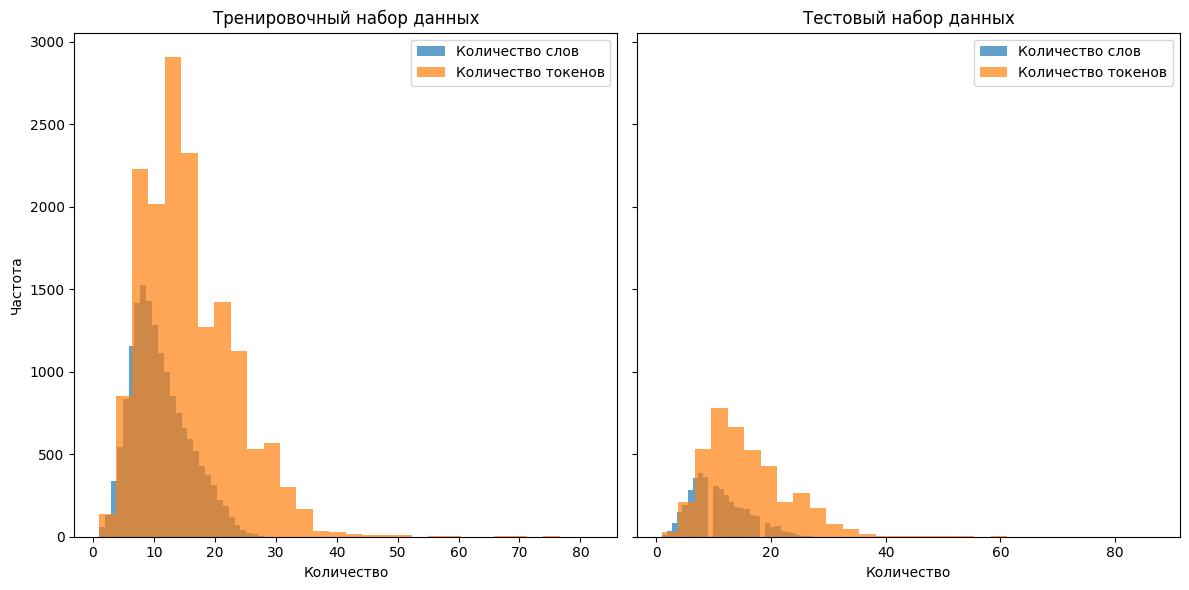

In [ ]:
import matplotlib.pyplot as plt

# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [len(example['text'].split()) for example in dataset['train']]

train_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['train']]

test_word_counts = [len(example['text'].split()) for example in dataset['test']]
test_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['test']]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[0].set_title('Тренировочный набор данных')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[1].set_title('Тестовый набор данных')
axes[1].set_xlabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=80,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/15998 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 15998
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [ ]:
# текст был успешно закодирован, более он нам не нужен
dataset = dataset.remove_columns('text')

In [ ]:
# переносим на гпу
dataset.set_format(type='torch', device='cuda')

In [ ]:
import torch
from torch.utils.data import DataLoader

# создаем загрузчики данных
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=16)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)

Что подается на вход модели?

- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: (в случае обучения) вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
next(iter(train_dataloader))

{'labels': tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0'),
 'input_ids': tensor([[   8, 3639, 1874,  ...,    0,    0,    0],
         [ 118,  135,   10,  ...,    0,    0,    0],
         [1662,   13,   56,  ...,    0,    0,    0],
         ...,
         [ 837,  229,    9,  ...,    0,    0,    0],
         [   6, 7476,   82,  ...,    0,    0,    0],
         [  35,   17, 5376,  ...,    0,    0,    0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

# Инициализация и обучение модели

In [ ]:
from transformers import get_scheduler
from torch.optim import AdamW

# оптимизатор AdamW, лр стоит поперебирать
optimizer = AdamW(model.parameters(), lr=1e-4)
# количество эпох можно побольше поставить
num_epochs = 3
# количество шагов
num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * len(train_dataloader)), # ~10% от общего числа шагов оптимально
    num_training_steps=num_training_steps
)

In [ ]:
!pip install evaluate

import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import torch
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# Задаем начальное значение лучшего F1
best_f1 = 0.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

running_loss = []
# Проходимся по всем эпохам
for epoch in range(num_epochs):
    print(40*'-', f'\nEpoch {epoch+1}')

    # Переводим модель в режим обучения
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc='Training')

    # Итерируемся по данным для обучения
    for i, batch in enumerate(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        # Получаем прогнозы и потери от модели
        outputs = model(**batch)
        loss = outputs.loss

        # Выполняем обратное распространение и шаг оптимизатора
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Обновляем планировщик скорости обучения
        optimizer.zero_grad()  # Очищаем градиенты

        running_loss.append(loss.item())
        pbar.set_postfix({'running_loss': np.mean(running_loss[-25:])})

    # Валидация модели
    print('\nValidating...')
    model.eval()  # Переводим модель в режим валидации

    # Инициализируем метрики
    f1 = evaluate.load('f1', trust_remote_code=True)
    acc = evaluate.load('accuracy', trust_remote_code=True)
    precision = evaluate.load('precision', trust_remote_code=True)
    recall = evaluate.load('recall', trust_remote_code=True)

    val_loss = []

    pbar = tqdm(test_dataloader, total=len(test_dataloader), desc='Validation')
    # Итерируемся по валидационным данным
    for batch in tqdm(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():  # Выполняем без расчета градиентов
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)

        # Обновляем метрики
        f1.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        acc.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        precision.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        recall.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())

        # Сохраняем потери
        val_loss.append(outputs.loss.item())
        pbar.set_postfix({'val_loss': np.mean(val_loss[-25:])})

    # Выводим итоги по метрикам
    print('Weighted Summary:')
    test_acc = acc.compute()['accuracy']
    test_precision = precision.compute(average='weighted')['precision']
    test_recall = recall.compute(average='weighted')['recall']
    f1_weighted = f1.compute(average='weighted')['f1']
    print(f'[{epoch+1}] Test Accuracy: {test_acc:.4f}')
    print(f'[{epoch+1}] Test Precision: {test_precision:.4f}')
    print(f'[{epoch+1}] Test Recall: {test_recall:.4f}')
    print(f'[{epoch+1}] Test F1: {f1_weighted:.4f}')

    # Сохраняем модель при улучшении F1
    if f1_weighted > best_f1:
        best_f1 = f1_weighted
        model.save_pretrained(f"best_model_nov_2021_f1_max={best_f1}_len=100")
        print(f"New best F1: {best_f1}. Model saved.")

---------------------------------------- 
Epoch 1


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Плато small bert модели и large T5 с большой выборкой на русском языке:

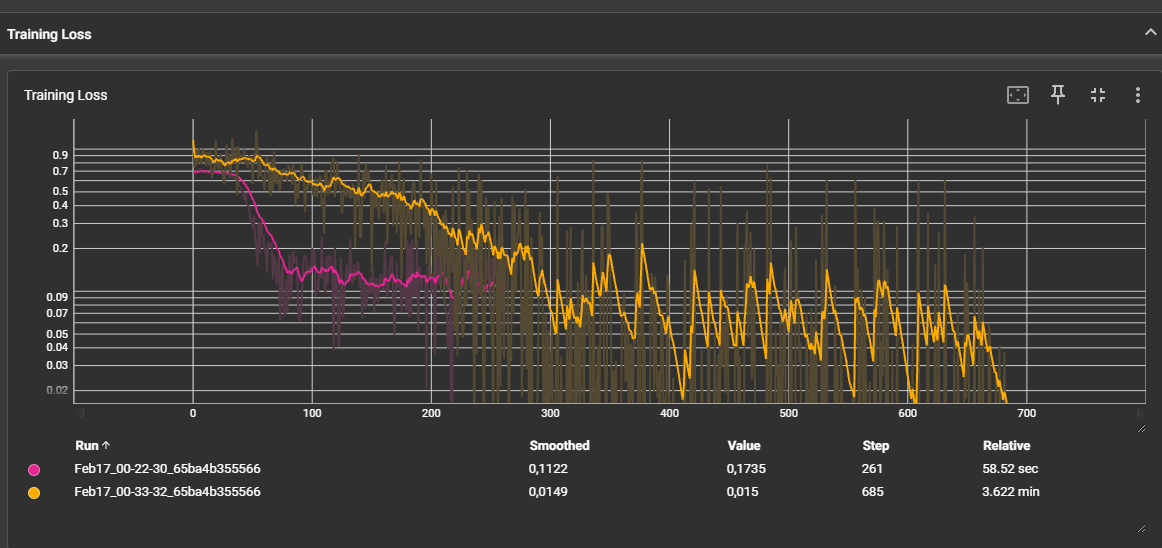

# обучение модели при помощи API-Trainer

Унифицированный класс Trainer необходим для тренировки моделей для разных задачах NLP и не только. Встроенных аргументов достаточно [много](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer). Фактический код, использующий Trainer, будет таким же, как и раньше; единственные изменения - это функция вычисления метрики.

In [ ]:
! pip install -U accelerate
! pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 877.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from transformers import Trainer, TrainingArguments
import evaluate

# Загрузка метрики вне функции
f1_metric = evaluate.load('f1', trust_remote_code=True)

# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results",  # Каталог для сохранения результатов обучения
    num_train_epochs=3,  # Количество эпох обучения
    per_device_train_batch_size=8,  # Размер батча для обучения
    per_device_eval_batch_size=8,  # Размер батча для валидации
    warmup_steps=500,  # Количество шагов разогрева
    weight_decay=0.01,  # Сила L2 регуляризации
    logging_dir="./runs",  # Каталог для логов TensorBoard
    logging_steps=500,  # Логирование каждые 500 шагов
#    evaluation_strategy="epoch",  # Стратегия оценки
    save_strategy="epoch",  # Стратегия сохранения модели
#    load_best_model_at_end=True,  # Загрузка лучшей модели в конце
    metric_for_best_model="f1",  # Метрика для выбора лучшей модели
    greater_is_better=True,  # Указывает, что большее значение F1 лучше
)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average="binary")

trainer = Trainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["test"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

NameError: name 'dataset' is not defined

In [ ]:
# Запускаем обучение
trainer.train()